In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE          # oversampling
from imblearn.pipeline import Pipeline            # pipeline compatibile
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [2]:
# Importing the dataset
clean_credit_card_data = pd.read_csv('Dataset/cleaned_credit_card_data_final.csv')

In [3]:
# -------- drop delle righe con target = 0 ------------
clean_credit_card_data = clean_credit_card_data[clean_credit_card_data["Credit_Score"] != 0].copy()   # .copy() per sicurezza (evita SettingWithCopyWarning)

print("Distribuzione dopo il drop della classe 0:")
print(clean_credit_card_data["Credit_Score"].value_counts(dropna=False))


Distribuzione dopo il drop della classe 0:
Credit_Score
2    52974
1    28953
3    17721
Name: count, dtype: int64


## 1) Decision Tree Classifier

Decision trees are a type of supervised learning algorithm that can be used for both classification and regression tasks. They work by splitting the data into subsets based on the value of input features, creating a tree-like structure where each node represents a feature and each branch represents a decision based on that feature.



In [4]:
# Importing necessary libraries for model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Selecting the target variable and features
X = clean_credit_card_data.drop(columns=['Credit_Score'])
y = clean_credit_card_data['Credit_Score']

# Encoding categorical variables if any
X = pd.get_dummies(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# 4.1 – calcoliamo quante osservazioni ha la classe di maggioranza
maj_size = y_train.value_counts().max()

# 4.2 – facciamo in modo che TUTTE le altre classi vengano portate a quella taglia
smote = SMOTE(
    sampling_strategy='not majority',  # ovvero: oversampla tutte tranne la più grande
    k_neighbors=5,                     # riduci a 3 se le classi 0/3 hanno < 5 es.
    random_state=42
)


In [6]:
# # Build the Decision Tree model with a maximum of 10 features
# decision_tree_model = DecisionTreeClassifier(random_state=42, max_features=10)
# decision_tree_model.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = decision_tree_model.predict(X_test)

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))
# print("\nAccuracy:")
# print(decision_tree_model.score(X_test, y_test))

In [7]:
clf = DecisionTreeClassifier(random_state=42, max_features=10)

pipe = Pipeline([
    ('smote', smote),        # <-- viene applicato SOLO sul training interno di CV
    ('model', clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_train, y_train,
                         cv=cv, scoring='f1_macro')   # macro = pesa tutte le classi uguale
print(f"F1-macro medio CV: {scores.mean():.3f} ± {scores.std():.3f}")

F1-macro medio CV: 0.757 ± 0.003


In [8]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))


Confusion matrix:
[[4545 1309   13]
 [1392 8261  920]
 [   6  913 2571]]

Classification report:
              precision    recall  f1-score   support

           1       0.76      0.77      0.77      5867
           2       0.79      0.78      0.78     10573
           3       0.73      0.74      0.74      3490

    accuracy                           0.77     19930
   macro avg       0.76      0.76      0.76     19930
weighted avg       0.77      0.77      0.77     19930



In [9]:
tree_model = pipe.named_steps['model']   # perché nello step l’hai chiamato 'model'
# oppure: tree_model = pipe['model']


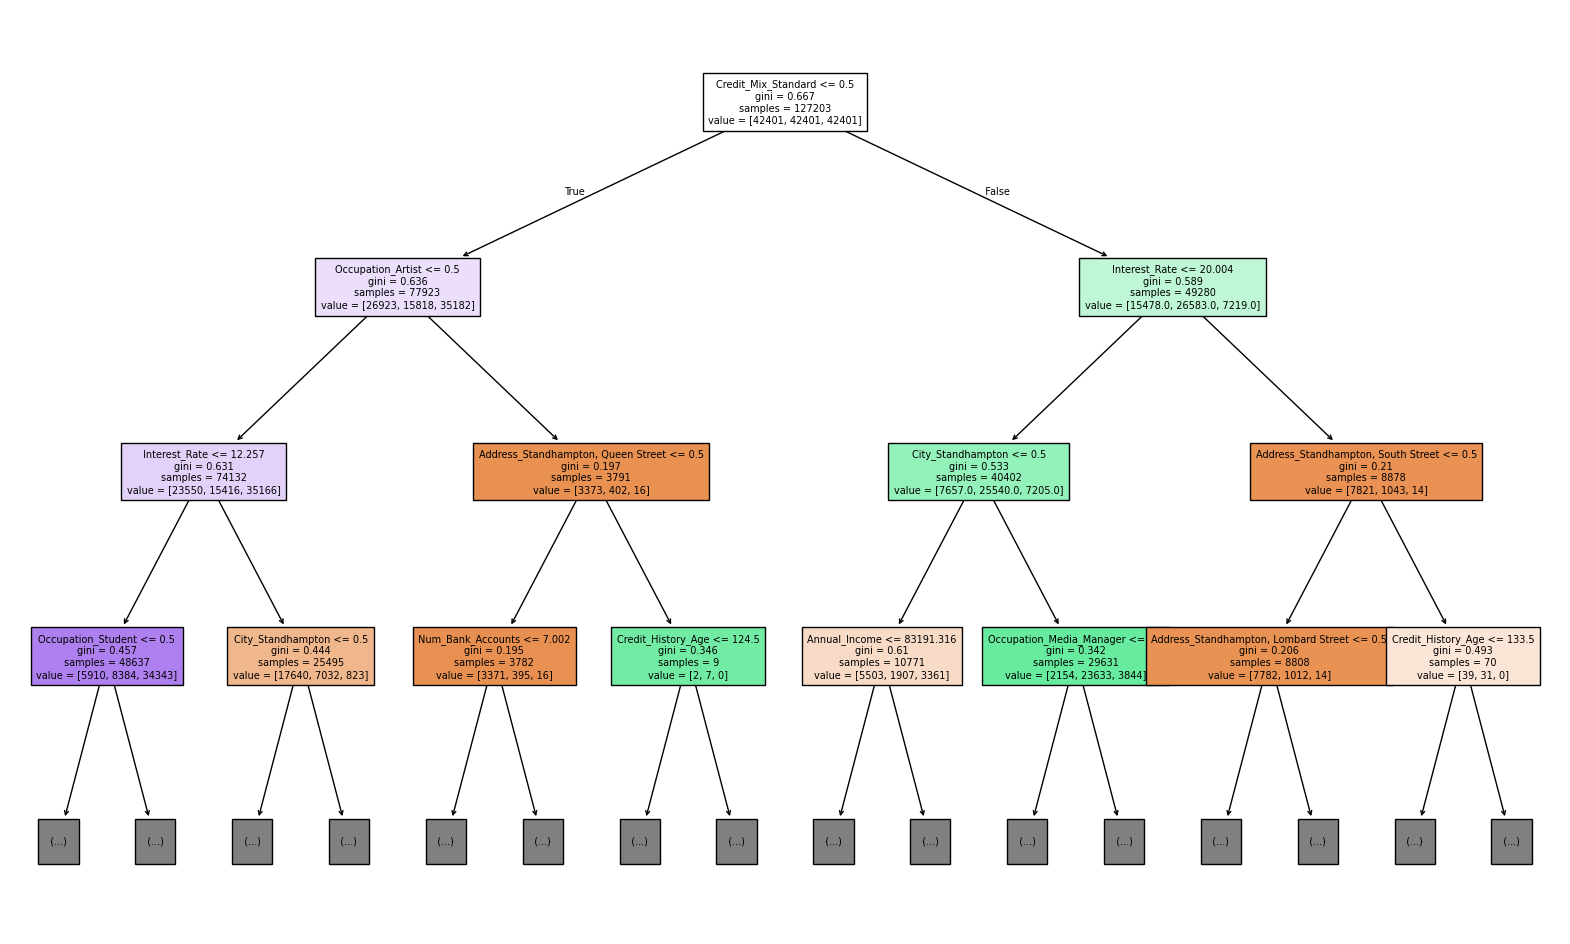

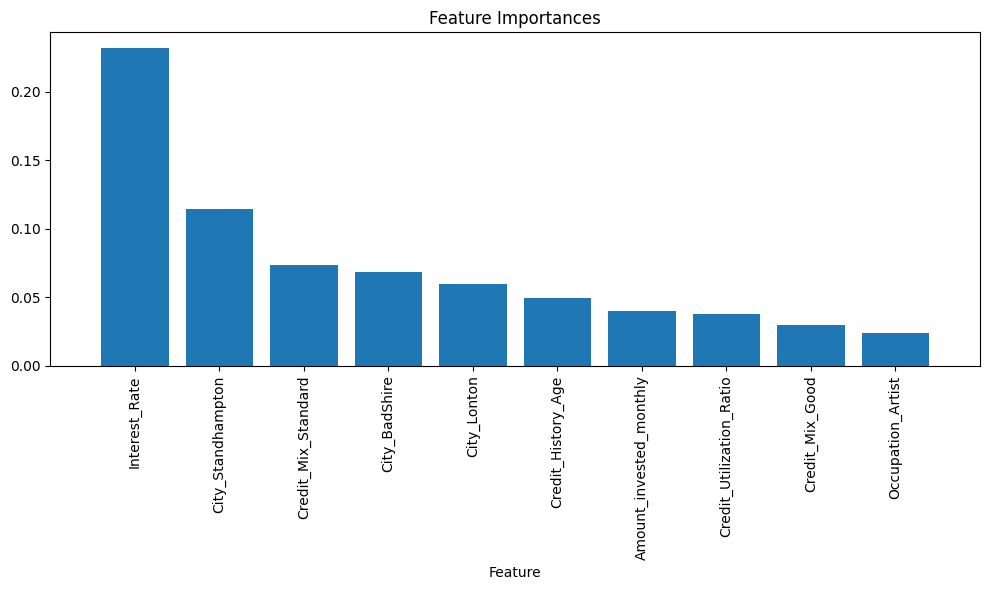

In [10]:
# Visualizing the Decision Tree with a maximum depth of 3
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 12))  # Increased figure size for better readability
plt.title("Decision Tree Visualization (max_depth=3)", fontsize=16)
plot_tree(tree_model, filled=True, feature_names=X.columns, max_depth=3, fontsize=7)
plt.show()

# Feature Importance
importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[indices]
importances = importances[indices]

# Plotting the feature importances (top 10)
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[:10], align='center')
plt.xticks(range(10), features[:10], rotation=90)
plt.xlim([-1, 10])
plt.xlabel("Feature")
plt.tight_layout()
plt.show()
